In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

# To prevent automatic figure display when execution of the cell ends
%config InlineBackend.close_figures=False 

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import torch.optim as optim
import torch
import torch.nn as nn

from sklearn.preprocessing import LabelEncoder

from models.mlp import BlackBoxModel

import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display,clear_output

import warnings
warnings.filterwarnings("ignore")

In [3]:
from dataset import GermanCreditDataset
from experiments import Benchmarking
from utils.logger_config import setup_logger
from tqdm import tqdm

logger = setup_logger()

In [5]:
from experiments.counterfactual import *
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

experiment = Benchmarking(
    dataset=GermanCreditDataset(),
    models=[
        (RandomForestClassifier(), 'sklearn'), 
        # (AdaBoostClassifier(), 'sklearn'), 
        # (SVC(probability=True), 'sklearn')
    ],
    shapley_methods=[
        "independent_X_counterfactual",
        "independent_X_train",
        "joint_probability_X_counterfactual",
        "joint_probability_X_train",
    ],
    distance_metrics=[
        'optimal_transport',
        'mean_difference',
        'max_mean_discrepancy',
    ]
)

experiment.train_and_evaluate_models(random_state=57)
experiment.models_performance()

# Compute Factuals
sample_num = 50
X_test = experiment.X_test
target_name = experiment.dataset.target_name
X_test_ext = X_test.copy()
X_test_ext[target_name] = experiment.y_test
indices = (X_test[X_test_ext[target_name]==0].sample(sample_num)).index
df_factual = X_test.loc[indices]

counterfactual_algorithms = [
    'DiCE',
    'DisCount',
]
logger.info("\n\n------Compute Counterfactuals------")
model_counterfactuals = {}
for model, model_name in zip(experiment.models, experiment.model_names):
    model_counterfactuals[model_name] = {}

    for algorithm in counterfactual_algorithms:
        logger.info(f'Computing {model_name} counterfactuals with {algorithm}')
        function_name = f"compute_{algorithm}_counterfactuals"
        try:
            func = globals()[function_name]
            model_counterfactuals[model_name][algorithm] = func(
                df_factual = df_factual,
                model = model,
                target_name = experiment.dataset.target_name,
            )
        except KeyError:
            print(f"Function {function_name} is not defined.")




INFO:root:RandomForestClassifier accuracy: 0.785
INFO:root:

------Compute Counterfactuals------
INFO:root:Computing RandomForestClassifier counterfactuals with DiCE
100%|██████████| 50/50 [03:39<00:00,  4.39s/it]


In [6]:
logger.info("\n\n------Compute Shapley Values------")
experiment.compute_shapley_values(
    X_factual=df_factual.values,
    model_counterfactuals=model_counterfactuals,
);

INFO:root:

------Compute Shapley Values------
INFO:root:Shapley values for RandomForestClassifier using independent_X_counterfactual with counterfactual by DiCE


  0%|          | 0/50 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.07040992,  0.01997468,  0.00528325, -0.02523056, -0.00945675,
       -0.01320675, -0.05732651, -0.04656032, -0.09288698])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([-0.05167873, -0.03024444, -0.01817397, -0.02479468,  0.03188413,
       -0.28646087,  0.02471222,  0.04838198, -0.02262563])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([-0.04877095, -0.03289476, -0.0003019 , -0.01406714, -0.0584681 ,
       -0.24790714, -0.02090095, -0.0326531 , -0.00303595])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([-0.01953905, -0.00034619, -0.00737214, -0.01739095,  0.01702024,
       -0.30747   , -0.07542857, -0.08906   , -0.01941333])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([-0.00199341, -0.03151651,  0.0008804 , -0.00947413,  0.01057111,
       -0.26415222, -0.03488175, -0.04082746,  0.02239397])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([-0.05401095,  0.03462048,  0.00099786, -0.01945048,

  0%|          | 0/50 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.07757897,  0.03983421,  0.02207349, -0.01987722, -0.00266484,
        0.07318444, -0.03237865, -0.00094746, -0.05320294])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([-0.04060992, -0.01986206, -0.00969492, -0.02369611,  0.01777937,
       -0.15808849,  0.07407389,  0.08755984, -0.00386159])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([-0.02752286, -0.02399905,  0.00463452, -0.0119219 , -0.03632095,
       -0.13619976,  0.00726286, -0.01656952,  0.03423667])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.00101286,  0.00557524, -0.0070131 , -0.01362905,  0.00409071,
       -0.18075619, -0.05307333, -0.04921857,  0.02661143])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.02567984, -0.02384825,  0.00309984, -0.00559206,  0.00202794,
       -0.14200587,  0.00461817, -0.0270223 ,  0.0666427 ])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([-0.0154919 ,  0.05264143,  0.00562   , -0.01612476,

In [17]:
logger.info("\n\n------Evaluating Distance Performance Under Interventions------")
experiment.evaluate_distance_performance_under_interventions(
    intervention_num_list=[0, 25, 50, 75, 100, 150, 200, 250, 300, 400],
    trials_num=50,
)


INFO:root:

------Evaluating Distance Performance Under Interventions------
INFO:root:Computing optimal_transport for (RandomForestClassifier, DiCE, independent_X_counterfactual)
100%|██████████| 50/50 [00:05<00:00,  9.27it/s]
INFO:root:Computing kl_divergence for (RandomForestClassifier, DiCE, independent_X_counterfactual)
100%|██████████| 50/50 [00:05<00:00,  9.65it/s]
INFO:root:Computing mean_difference for (RandomForestClassifier, DiCE, independent_X_counterfactual)
100%|██████████| 50/50 [00:04<00:00, 11.05it/s]
INFO:root:Computing max_mean_discrepancy for (RandomForestClassifier, DiCE, independent_X_counterfactual)
100%|██████████| 50/50 [00:27<00:00,  1.80it/s]
INFO:root:Computing optimal_transport for (RandomForestClassifier, DiCE, independent_X_train)
100%|██████████| 50/50 [00:04<00:00, 10.23it/s]
INFO:root:Computing kl_divergence for (RandomForestClassifier, DiCE, independent_X_train)
100%|██████████| 50/50 [00:04<00:00, 10.09it/s]
INFO:root:Computing mean_difference for (Ra

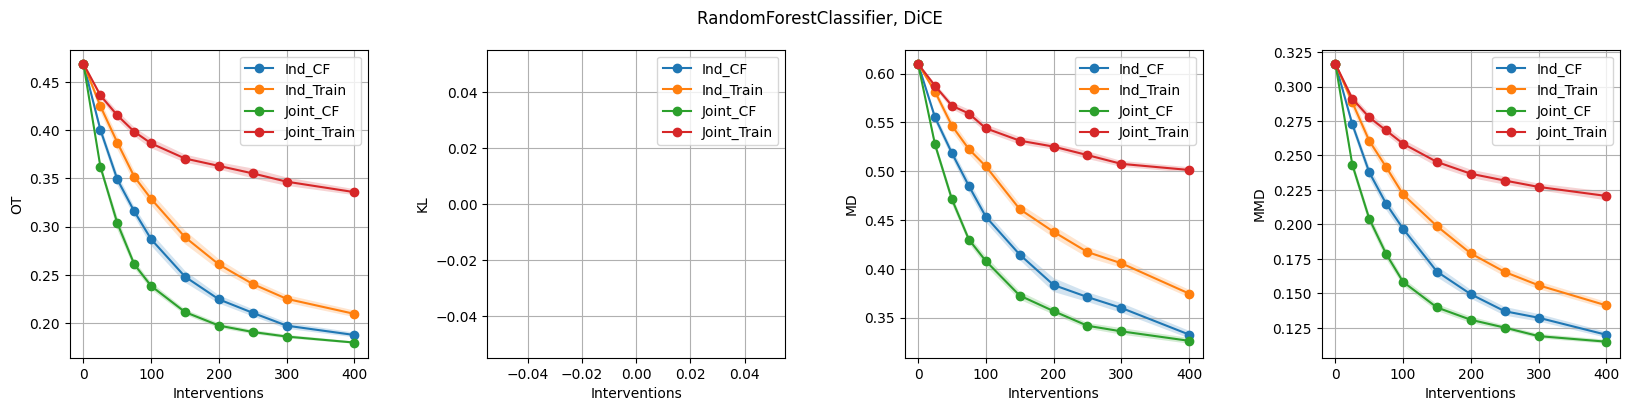

In [55]:
from experiments import plotting

plotting.intervention_vs_distance(experiment)